In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier




In [30]:
genreAll = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/GenreAll.csv")
for col in genreAll.columns:
    genreAll.rename(columns={col:col.strip()}, inplace = True)
feat_30 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_30_sec.csv")
feat_3 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_3_sec.csv")


In [31]:
feat_3

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


## Data Overview

### GenreAll dataset

Nbr of observations: 992
Nbr of features: 240
  Textual column : highlevel_speech_music_value (values: ['speech' 'music'])
  Textual column : highlevel_voice_instrumental_value (values: ['instrumental' 'voice'])
  Textual column : tonal_key_mode_value (values: ['major' 'minor'])
  Textual column : genre (values: ['blu' 'cla' 'cou' 'dis' 'hip' 'jaz' 'met' 'pop' 'reg' 'roc'])

Nbr of classes: 10


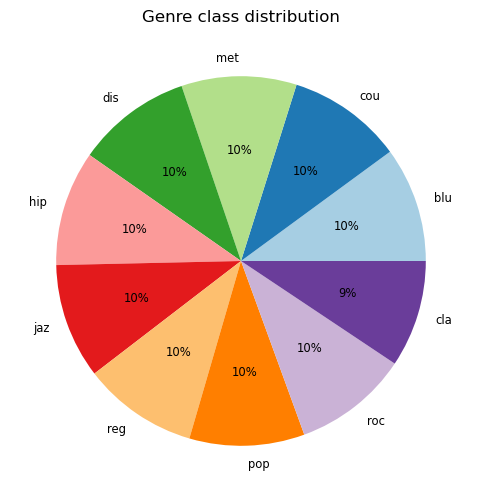

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
nrows, ncols = genreAll.shape
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-1}")

for col in genreAll.columns:
    if genreAll[col].isna().sum()!=0: print(f"{genreAll[col].isna().sum()} NaN found in col {col}")
    if isinstance(genreAll[col][0], str):
        print(f'  Textual column : {col} (values: {genreAll[col].unique()})')
    else:
        genreAll[col] = scaler.fit_transform(genreAll[[col]].fillna(0))
print(f"\nNbr of classes: {pd.unique(genreAll.genre).size}")

count_df = genreAll['genre'].value_counts().reset_index()
count_df.columns = ['values', 'counts']
fig, ax = plt.subplots(figsize=(24, 6))
colors = plt.cm.Paired.colors  # e.g. 'Paired', 'viridis', 'Set3', etc.

ax.pie(count_df.counts, labels=count_df['values'], autopct='%.0f%%',
       textprops={'size': 'smaller'}, radius=1,
       colors=colors[:len(count_df)])
plt.title('Genre class distribution')
plt.show()


In [19]:

#replace string-valued rows with integers
genre_dict = {'blu':0, 'cla':1, 'cou':2, 'dis':3, 'hip':4, 'jaz':5, 'met':6, 'pop':7, 'reg':8,'roc':9}
highlevel_speech_music_value_dict = {'music':0, 'speech':1}
highlevel_voice_instrumental_value_dict = {'instrumental':0, 'voice':1}
tonal_key_mode_value_dict = {'minor':0, 'major':1}

genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
genreAll['highlevel_voice_instrumental_value'] = genreAll['highlevel_voice_instrumental_value'].replace(highlevel_voice_instrumental_value_dict)
genreAll['tonal_key_mode_value'] = genreAll['tonal_key_mode_value'].replace(tonal_key_mode_value_dict)
genreAll['genre'] = genreAll['genre'].replace(genre_dict)


/tmp/ipykernel_12025/1340540508.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
/tmp/ipykernel_12025/1340540508.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genreAll['highlevel_voice_instrumental_value'] = genreAll['highlevel_voice_instrumental_value'].replace(highlevel_voice_instrumental_value_dict)
/tmp/ipykernel_12025/1340540508.py:9: FutureWarning: Downcasting behavior in `replace` is deprec

### Feat30 dataset

Nbr of observations: 999
Nbr of features: 57
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])

Nbr of classes: 10


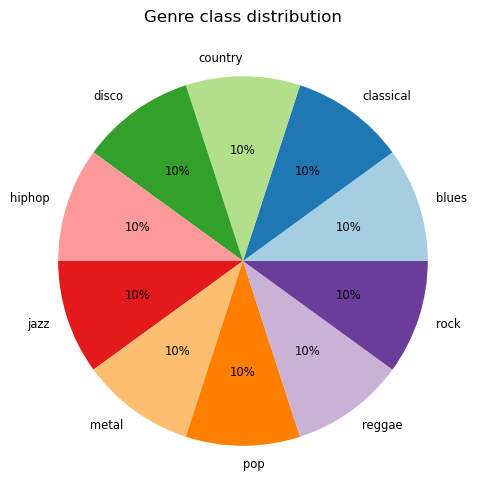

In [20]:
feat_30 = feat_30[feat_30.columns[2:]] #revome filename and length columns
nrows, ncols = feat_30.shape
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-1}")

for col in feat_30.columns[1:]:
    if isinstance(feat_30[col][0], str): print(f'  Textual column : {col} (values: {feat_30[col].unique()})')
    else:
        feat_30[col] = (feat_30[col]-feat_30[col].min())/(feat_30[col].max()-feat_30[col].min())


print(f"\nNbr of classes: {pd.unique(feat_30.label).size}")

count_df = feat_30['label'].value_counts().reset_index()
count_df.columns = ['values', 'counts']
fig, ax = plt.subplots(figsize=(24, 6))
colors = plt.cm.Paired.colors  # e.g. 'Paired', 'viridis', 'Set3', etc.

ax.pie(count_df.counts, labels=count_df['values'], autopct='%.0f%%',
       textprops={'size': 'smaller'}, radius=1,
       colors=colors[:len(count_df)])
plt.title('Genre class distribution')
plt.show()


In [21]:
#replace string-valued rows with integers
feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_30['label'] = feat_30['label'].replace(feat_label_dict)

/tmp/ipykernel_12025/1745162631.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feat_30['label'] = feat_30['label'].replace(feat_label_dict)


### Feat3 dataset

Nbr of observations: 9989
Nbr of features: 57
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])

Nbr of classes: 10


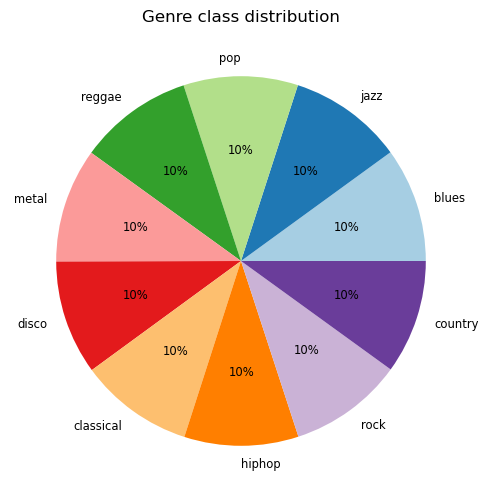

In [22]:
feat_3 = feat_3[feat_3.columns[2:]] #revome filename and length columns
nrows, ncols = feat_3.shape
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-1}")

for col in feat_3.columns[1:]:
    if isinstance(feat_3[col][0], str): print(f'  Textual column : {col} (values: {feat_3[col].unique()})')
    else:
        feat_3[col] = (feat_3[col]-feat_3[col].min())/(feat_3[col].max()-feat_3[col].min())

print(f"\nNbr of classes: {pd.unique(feat_3.label).size}")

count_df = feat_3['label'].value_counts().reset_index()
count_df.columns = ['values', 'counts']
fig, ax = plt.subplots(figsize=(24, 6))
colors = plt.cm.Paired.colors  # e.g. 'Paired', 'viridis', 'Set3', etc.

ax.pie(count_df.counts, labels=count_df['values'], autopct='%.0f%%',
       textprops={'size': 'smaller'}, radius=1,
       colors=colors[:len(count_df)])
plt.title('Genre class distribution')
plt.show()


In [23]:
#replace string-valued rows with integers
feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_3['label'] = feat_3['label'].replace(feat_label_dict)

/tmp/ipykernel_12025/2499018718.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feat_3['label'] = feat_3['label'].replace(feat_label_dict)


## Train-test splits

In [9]:
from sklearn.model_selection import train_test_split
data = {
    'genreAll':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_30':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_3':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
}

data['genreAll']['X_train'], data['genreAll']['X_test'], data['genreAll']['y_train'], data['genreAll']['y_test'] = train_test_split(genreAll[genreAll.columns[:-1]], genreAll.genre, test_size=0.20)
data['feat_30']['X_train'], data['feat_30']['X_test'], data['feat_30']['y_train'], data['feat_30']['y_test'] = train_test_split(feat_30[feat_30.columns[:-1]], feat_30.label, test_size=0.20)
data['feat_3']['X_train'], data['feat_3']['X_test'], data['feat_3']['y_train'], data['feat_3']['y_test'] = train_test_split(feat_3[feat_3.columns[:-1]], feat_3.label, test_size=0.20)

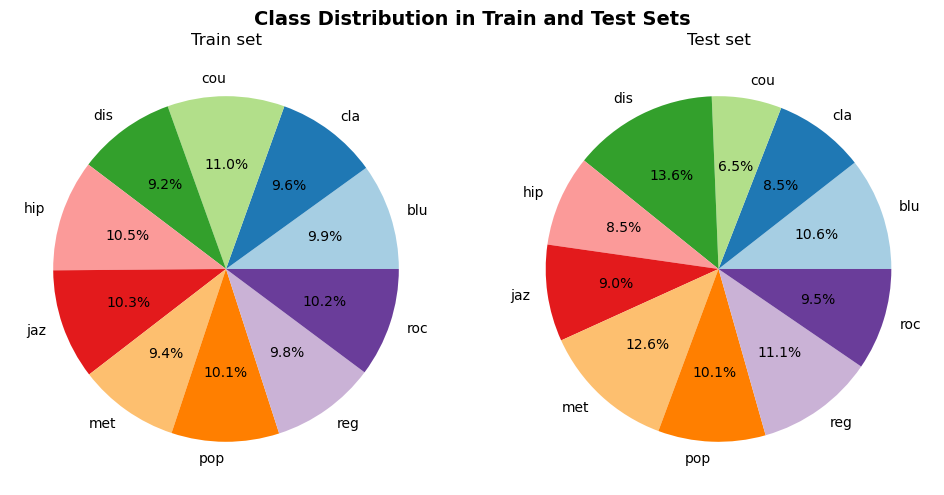

In [10]:
# check that the random split is representative

# Invert tag dictionary (int -> string)
inv_genre_dic = {v: k for k, v in genre_dict.items()}

# Count occurrences
train_counts = data['genreAll']['y_train'].value_counts().sort_index()
test_counts = data['genreAll']['y_test'].value_counts().sort_index()

# Convert to label names using the inverted map
train_labels = [inv_genre_dic[i] for i in train_counts.index]
test_labels = [inv_genre_dic[i] for i in test_counts.index]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Train pie ---
wedges1, _,_ = axes[0].pie(

    train_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(train_labels)],
)
axes[0].set_title('Train set')

# --- Test pie ---
wedges2, _,_ = axes[1].pie(
    test_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(test_labels)],
)
axes[1].set_title('Test set')

fig.suptitle('Class Distribution in Train and Test Sets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

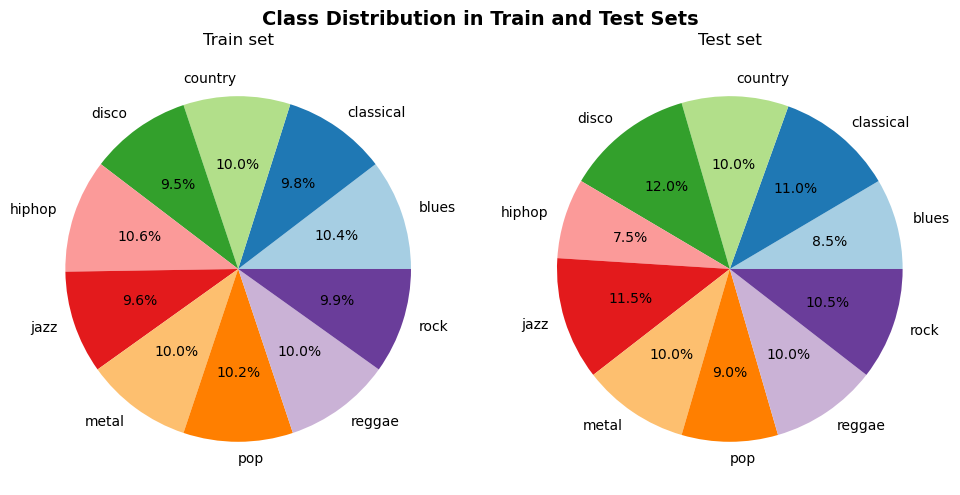

In [11]:
# check that the random split is representative
# Invert tag dictionary (int -> string)
inv_feat_label_dict = {v: k for k, v in feat_label_dict.items()}

# Count occurrences
train_counts = data['feat_30']['y_train'].value_counts().sort_index()
test_counts = data['feat_30']['y_test'].value_counts().sort_index()

# Convert to label names using the inverted map
train_labels = [inv_feat_label_dict[i] for i in train_counts.index]
test_labels = [inv_feat_label_dict[i] for i in test_counts.index]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Train pie ---
wedges1, _,_ = axes[0].pie(

    train_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(train_labels)],
)
axes[0].set_title('Train set')

# --- Test pie ---
wedges2, _,_ = axes[1].pie(
    test_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(test_labels)],
)
axes[1].set_title('Test set')

fig.suptitle('Class Distribution in Train and Test Sets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

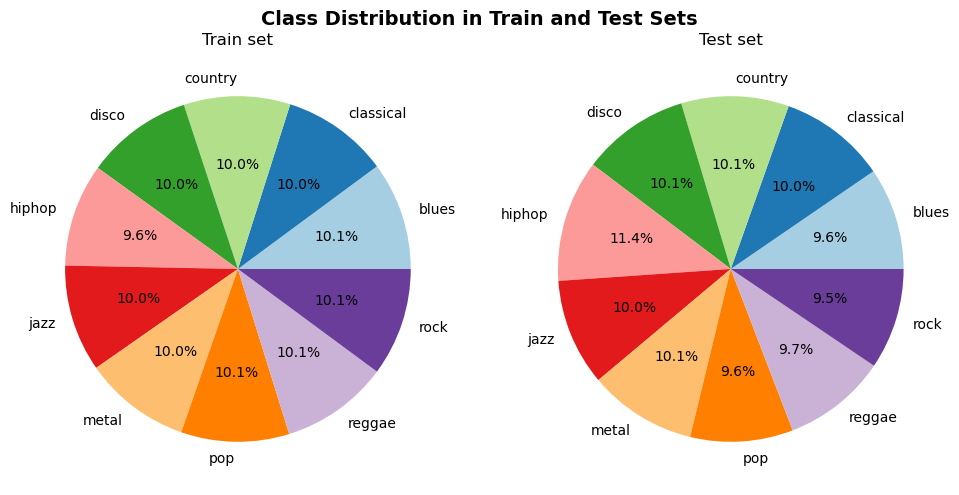

In [12]:
# check that the random split is representative
# Invert tag dictionary (int -> string)
inv_feat_label_dict = {v: k for k, v in feat_label_dict.items()}

# Count occurrences
train_counts = data['feat_3']['y_train'].value_counts().sort_index()
test_counts = data['feat_3']['y_test'].value_counts().sort_index()

# Convert to label names using the inverted map
train_labels = [inv_feat_label_dict[i] for i in train_counts.index]
test_labels = [inv_feat_label_dict[i] for i in test_counts.index]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Train pie ---
wedges1, _,_ = axes[0].pie(

    train_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(train_labels)],
)
axes[0].set_title('Train set')

# --- Test pie ---
wedges2, _,_ = axes[1].pie(
    test_counts,
    autopct='%1.1f%%',
    labels=train_labels,
    colors=colors[:len(test_labels)],
)
axes[1].set_title('Test set')

fig.suptitle('Class Distribution in Train and Test Sets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Logistic Regression

/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


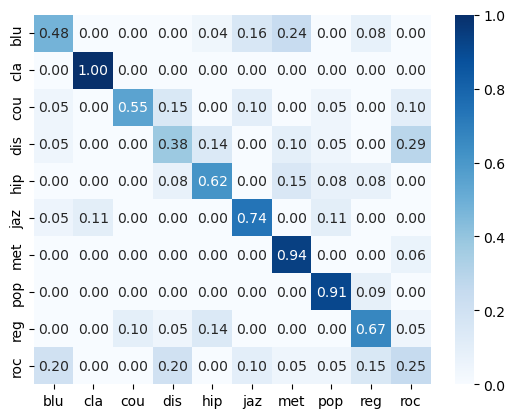

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train = data['feat_30']['X_train']
y_train = data['feat_30']['y_train']
X_test = data['feat_30']['X_test']
y_test = data['feat_30']['y_test']

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

label_names = [i for i in genre_dict.keys()]
singleClass_cm = multilabel_confusion_matrix(y_test, y_pred,
                            labels=genreAll.genre.unique()) #tn, fn, fp, tp

cm = confusion_matrix(y_test, y_pred,
                            labels=genreAll.genre.unique(), normalize='true') #tn, fn, fp, tp
df_cfm = pd.DataFrame(cm, index=label_names, columns=label_names)
cfm_plot = sn.heatmap(df_cfm,annot=df_cfm,fmt=".2f",cmap="Blues")



In [14]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
kf = KFold(n_splits=10)
score = cross_val_score(clf, X_train,y_train, cv=kf)
#score = cross_validate(clf, X_train,y_train, cv=kf, scoring=['accuracy', 'f1_micro'])
print(f"Avg acc: {score.mean()}, avg sd: {score.std()}")


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://sci

Avg acc: 0.64375, avg sd: 0.06452954749570154


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://sci

## k-Nearest Neigbours

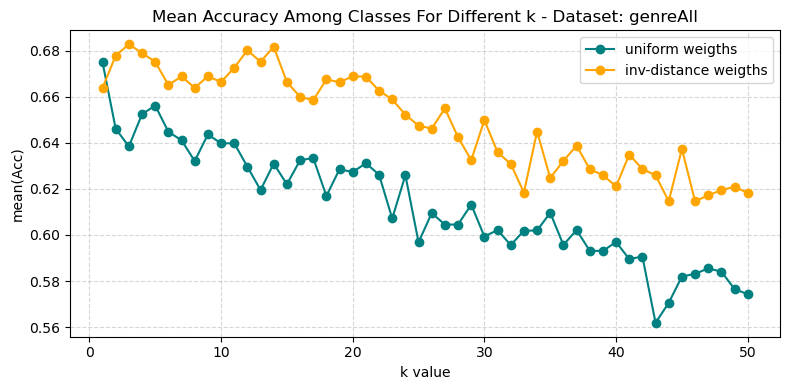

Best AccScore for uniformly weigthed distances: 0.6749 ± 0.0458441564304274 (k = 1)
Best AccScore for inv-dist weigthed distances: 0.6827 ± 0.02972885684142431 (k = 3)


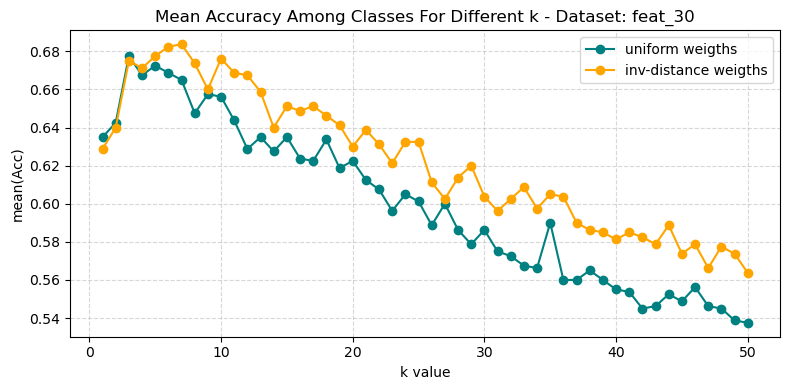

Best AccScore for uniformly weigthed distances: 0.6775 ± 0.04322904116447648 (k = 3)
Best AccScore for inv-dist weigthed distances: 0.6837 ± 0.0474341649025257 (k = 7)


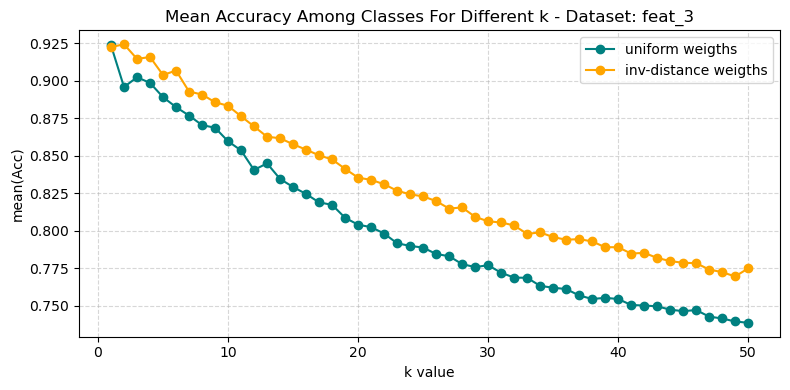

Best AccScore for uniformly weigthed distances: 0.9235 ± 0.010032096686371774 (k = 1)
Best AccScore for inv-dist weigthed distances: 0.9243 ± 0.004000348441480327 (k = 2)


In [22]:
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=10, shuffle=True)


for dataset in data.keys():
    avg_acc_kn = []
    std_acc_kn = []
    avg_acc_kn_dist = []
    std_acc_kn_dist = []
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    for k in range(1,51,1):
    #uniform distance
        neigh = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn.append(scores.mean())
        std_acc_kn.append(scores.std())
    #inv-distnace
        neigh = KNeighborsClassifier(n_neighbors=k, weights='distance') #weight points by the inverse of their distance
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn_dist.append(scores.mean())
        std_acc_kn_dist.append(scores.std())

    plt.figure(figsize=(8, 4))
    plt.plot(range(1,51,1),avg_acc_kn,'o-', color='teal', label='uniform weigths')
    plt.plot(range(1,51,1),avg_acc_kn_dist,'o-', color='orange', label='inv-distance weigths')
    plt.title(f"Mean Accuracy Among Classes For Different k - Dataset: {dataset}")
    plt.xlabel("k value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print(f"Best AccScore for uniformly weigthed distances: {max(avg_acc_kn):.4f} ± {std_acc_kn[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn)+1})")
    print(f"Best AccScore for inv-dist weigthed distances: {max(avg_acc_kn_dist):.4f} ± {std_acc_kn_dist[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn_dist)+1})")



## Desicion trees

In [ ]:
clf = tree.DecisionTreeClassifier()
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']

    clf = tree.DecisionTreeClassifier(criterion='gini')
    scores_gini = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='entropy')
    scores_entropy = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='log_loss')
    scores_log_loss = cross_val_score(clf, X_train,y_train, cv=kf)
    print("Dataset:", dataset)
    print(f"Avg AccScore for gini criterion: {scores_gini.mean():.4f} ± {scores_gini.std():.4f}")
    print(f"Avg AccScore for entropy criterion: {scores_entropy.mean():.4f} ± {scores_entropy.std():.4f}")
    print(f"Avg AccScore for log_loss criterion: {scores_log_loss.mean():.4f} ± {scores_log_loss.std():.4f}")
    print('----------------------------------------------------------\n')




Dataset: genreAll
Avg AccScore for gini criterion: 0.6032 ± 0.0493
Avg AccScore for entropy criterion: 0.6449 ± 0.0551
Avg AccScore for log_loss criterion: 0.6032 ± 0.0508
----------------------------------------------------------
Dataset: feat_30
Avg AccScore for gini criterion: 0.4925 ± 0.0462
Avg AccScore for entropy criterion: 0.4963 ± 0.0475
Avg AccScore for log_loss criterion: 0.5175 ± 0.0543
----------------------------------------------------------
Dataset: feat_3
Avg AccScore for gini criterion: 0.6553 ± 0.0143
Avg AccScore for entropy criterion: 0.6494 ± 0.0086
Avg AccScore for log_loss criterion: 0.6637 ± 0.0097
----------------------------------------------------------


## Random Forest

In [27]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc_gini = []
    avg_acc_gini = []
    std_acc_entropy = []
    avg_acc_entropy = []
    std_acc_log_loss = []
    avg_acc_log_loss = []


    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    for n_est in range(50,151,10):
    #gini:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='gini')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_gini.append(scores.mean())
        std_acc_gini.append(scores.std())
    #entropy:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='entropy')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_entropy.append(scores.mean())
        std_acc_entropy.append(scores.std())
    #log_loss:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='log_loss')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_log_loss.append(scores.mean())
        std_acc_log_loss.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,151,10),avg_acc_gini,'o-', color='teal', label='gini')
    plt.plot(range(50,151,10),avg_acc_entropy,'o-', color='orange', label='entropy')
    plt.plot(range(50,151,10),avg_acc_log_loss,'o-', color='green', label='log_loss')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of estimators - Dataset: {dataset}")
    plt.xlabel("n_est value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    #data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print("Dataset:", dataset)
    print(f"Best AccScore for gini criterion: {max(avg_acc_gini):.4f} ± {std_acc_gini[np.argmax(avg_acc_gini)]:.4f} (nbr_est = {np.argmax(avg_acc_gini)*10+50})")
    print(f"Best AccScore for entropy criterion: {max(avg_acc_entropy):.4f} ±{std_acc_entropy[np.argmax(avg_acc_entropy)]:.4f}  (nbr_est = {np.argmax(avg_acc_entropy)*10+50})")
    print(f"Best AccScore for log_loss criterion: {max(avg_acc_log_loss):.4f} ± {std_acc_log_loss[np.argmax(avg_acc_log_loss)]:.4f} (nbr_est = {np.argmax(avg_acc_log_loss)*10+50})")
    print('----------------------------------------------------------\n')



KeyboardInterrupt: 

## Multi Layer Perceptron

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=150, max_iter=300)
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)
#
#kf = KFold(n_splits=10, shuffle=True)
#score = cross_val_score(clf, X_train,y_train, cv=kf)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

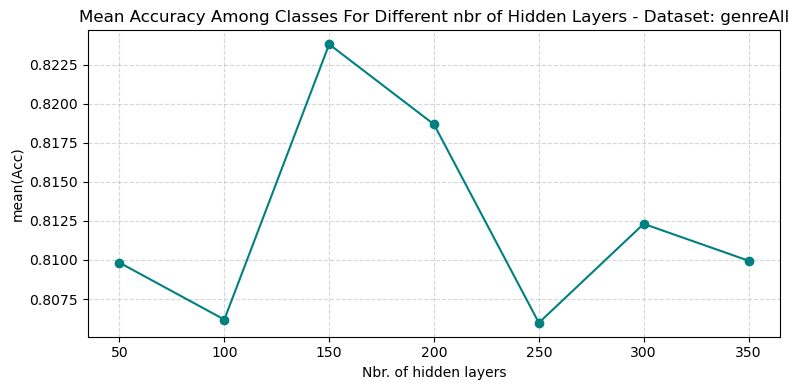

Dataset: genreAll
Best AccScore for gini criterion: 0.8238 ± 0.0273 (nbr. hidden layers = 150)
----------------------------------------------------------



/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

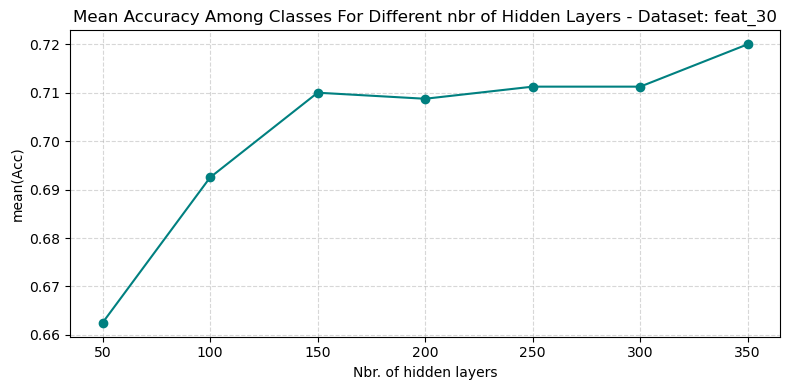

Dataset: feat_30
Best AccScore for gini criterion: 0.7200 ± 0.0396 (nbr. hidden layers = 350)
----------------------------------------------------------



/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc = []
    avg_acc = []

    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']

    for hidd_layers in range(50,351,50):
        clf = MLPClassifier(hidden_layer_sizes=hidd_layers, max_iter=300)
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc.append(scores.mean())
        std_acc.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,351,50),avg_acc,'o-', color='teal')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of Hidden Layers - Dataset: {dataset}")
    plt.xlabel("Nbr. of hidden layers")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    data[dataset]['best_hid_layers'] = (np.argmax(avg_acc)+1)*50
    print("Dataset:", dataset)
    print(f"Best AccScore for MLP: {max(avg_acc):.4f} ± {std_acc[np.argmax(avg_acc)]:.4f} (nbr. hidden layers = {(np.argmax(avg_acc)+1)*50})")
    print('----------------------------------------------------------\n')



## general loop

In [14]:

classifiers = [
    LogisticRegression(random_state=0, max_iter=300),
    KNeighborsClassifier(n_neighbors=4, weights='distance'), #weight points by the inverse of their distance
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=10, random_state=0),
    MLPClassifier(random_state=1, max_iter=300)
]

kf = KFold(n_splits=10, shuffle=True)
avg_acc = []
std_acc = []
models = ['LogisticRegression', '2-NN', 'Desicion Tree', 'Random Forest', 'MLP']

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    for clf in classifiers:
        print(clf)
        data[dataset]['train_scores'] = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc.append(data[dataset]['train_scores'].mean())
        std_acc.append(data[dataset]['train_scores'].std())

        clf.fit(X_train, y_train)
        data[dataset]['test_scores'] = clf.score(X_test,y_test)


    


LogisticRegression(max_iter=300, random_state=0)
KNeighborsClassifier(n_neighbors=4, weights='distance')
KNeighborsClassifier(n_neighbors=4, weights='distance')
DecisionTreeClassifier()
DecisionTreeClassifier()
RandomForestClassifier(max_depth=10, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
MLPClassifier(max_iter=300, random_state=1)
MLPClassifier(max_iter=300, random_state=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

LogisticRegression(max_iter=300, random_state=0)
KNeighborsClassifier(n_neighbors=4, weights='distance')
DecisionTreeClassifier()
KNeighborsClassifier(n_neighbors=4, weights='distance')
DecisionTreeClassifier()
RandomForestClassifier(max_depth=10, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
MLPClassifier(max_iter=300, random_state=1)
MLPClassifier(max_iter=300, random_state=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

LogisticRegression(max_iter=300, random_state=0)
KNeighborsClassifier(n_neighbors=4, weights='distance')
KNeighborsClassifier(n_neighbors=4, weights='distance')
DecisionTreeClassifier()
DecisionTreeClassifier()
RandomForestClassifier(max_depth=10, random_state=0)
RandomForestClassifier(max_depth=10, random_state=0)
MLPClassifier(max_iter=300, random_state=1)
MLPClassifier(max_iter=300, random_state=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (15,).

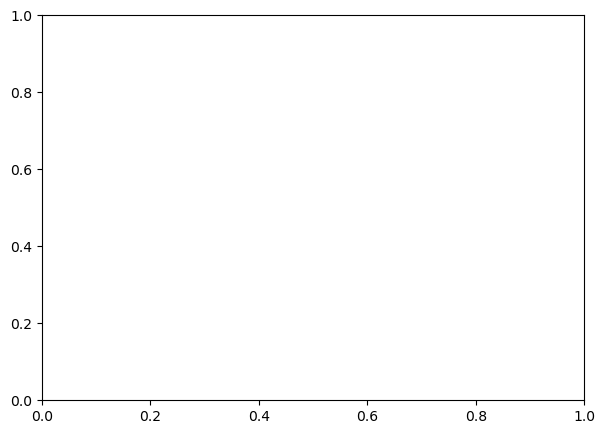

In [16]:


# X positions for the bars
x = np.arange(len(models))

plt.figure(figsize=(7,5))
bars = plt.bar(x, avg_acc, yerr=std_acc,  color='skyblue', edgecolor='k')

plt.xticks(x, models)
plt.ylabel('Accuracy')
plt.title('Model Performance (avg ± std)')
plt.ylim(0, 1)  # optional if your accuracies are between 0–1

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


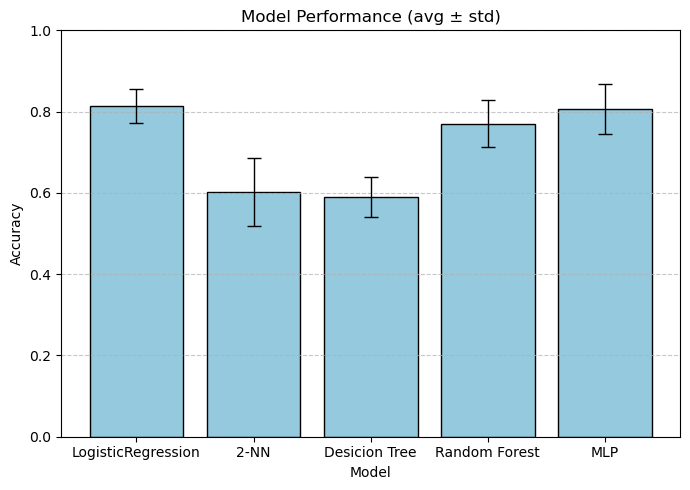

In [38]:
import seaborn as sns

df = pd.DataFrame({'Model': models, 'Avg Accuracy': avg_acc, 'Std': std_acc})

plt.figure(figsize=(7,5))
sns.barplot(data=df, x='Model', y='Avg Accuracy', color='skyblue', edgecolor='k')

# Add error bars manually
plt.errorbar(x=np.arange(len(df)), y=df['Avg Accuracy'], yerr=df['Std'], 
             fmt='none', ecolor='k', capsize=5, elinewidth=1)

plt.ylabel('Accuracy')
plt.title('Model Performance (avg ± std)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Feature extractions: 
### correlation matrix of specific variables?


In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

dataset='genreAll'
X_train = data[dataset]['X_train']
y_train = data[dataset]['y_train']
X_test = data[dataset]['X_test']
y_test = data[dataset]['y_test']

X_new = SelectKBest(f_classif, k=100).fit_transform(genreAll[genreAll.columns[:-1]],genreAll[genreAll.columns[-1]])
X_new.shape

/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 98 100] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(993, 100)

In [28]:
X_new.shape

(993, 100)

In [29]:
genreAll

,highlevel_danceability_value,highlevel_equalization_profile_value,highlevel_excitement_value,highlevel_intensity_value,highlevel_speech_music_value,highlevel_voice_instrumental_value,loudness_dynamic_complexity_dvar,loudness_dynamic_complexity_mean,loudness_dynamic_complexity_var,loudness_larm_dvar,...,tonal_chords_strength_dvar,tonal_chords_strength_mean,tonal_chords_strength_var,tonal_dissonance_dvar,tonal_dissonance_mean,tonal_dissonance_var,tonal_key_mode_value,tonal_key_strength_value,tonal_tuning_equal_tempered_deviation_value,genre
0,0.234392,0.666667,0.5,0.428571,1,0,0.113040,0.392104,0.176166,0.049058,...,0.021433,0.586575,0.272576,0.262219,0.697470,0.225204,1,0.730290,0.670292,0
1,0.212656,0.666667,0.0,0.285714,1,1,0.174609,0.523429,0.189037,0.041080,...,0.010329,0.470073,0.081218,0.328471,0.629248,0.276827,1,0.742604,0.191614,0
2,0.193491,0.666667,0.5,0.714286,0,0,0.131187,0.295586,0.226335,0.030835,...,0.015549,0.536820,0.271469,0.201300,0.798947,0.179831,1,0.885771,0.191053,0
3,0.209746,0.666667,0.5,0.285714,0,0,0.117560,0.172698,0.250007,0.009091,...,0.022735,0.702808,0.305201,0.155138,0.829960,0.088687,1,0.715286,0.256420,0
4,0.246717,0.000000,0.0,0.428571,1,0,0.126623,0.431693,0.173666,0.049893,...,0.010885,0.558417,0.064665,0.251245,0.684151,0.168612,1,0.640112,0.178971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,0.033900,0.666667,0.0,0.571429,0,0,0.201902,0.267310,0.294289,0.041326,...,0.003374,0.620030,0.249269,0.124464,0.673038,0.197017,1,0.939398,0.240701,9
989,0.175862,0.666667,1.0,0.571429,0,1,0.137812,0.217970,0.236092,0.024044,...,0.006105,0.585850,0.168419,0.026614,0.931868,0.021107,1,0.790822,0.180462,9
990,0.074169,0.666667,0.0,0.428571,0,0,0.133191,0.169992,0.256761,0.024000,...,0.001952,0.344067,0.083762,0.129356,0.746171,0.212208,1,0.588442,0.033006,9
991,0.160237,0.666667,0.0,0.571429,0,0,0.136153,0.158452,0.254037,0.006227,...,0.004596,0.757212,0.100773,0.174206,0.783714,0.092885,1,0.776315,0.134337,9
